<a href="https://colab.research.google.com/github/josh-truong/california-housing-kmeans/blob/main/california_housing_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [432]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [433]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import seaborn as sns
import matplotlib.pyplot as plt

In [434]:
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

In [435]:
df1 = pd.read_csv("/content/sample_data/california_housing_train.csv")
df2 = pd.read_csv("/content/sample_data/california_housing_test.csv")
df = pd.concat([df1,df2])
n_features = df.shape[1]
print(len(df))
df.head(5)

20000


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


# Feature Selection

In [436]:
# Todo for the future
# Feature Selection by Random Forest? Unsupervised

# Dataset Normalization

In [437]:
# Normalize data
data = StandardScaler().fit_transform(df)
data = pd.DataFrame(data)
data.columns = df.columns
print(len(data))
data.head(5)

20000


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,2.623418,-0.672608,-1.083122,1.367000,1.771212,-0.362998,-0.072109,-1.251656,-1.213134
1,2.543560,-0.574297,-0.765205,2.303469,3.240469,-0.262204,-0.095687,-1.079894,-1.098902
2,2.498640,-0.906681,-0.924164,-0.880893,-0.865368,-0.965993,-1.002110,-1.168880,-1.050440
3,2.493649,-0.930088,-1.162601,-0.522020,-0.477846,-0.805076,-0.716560,-0.358064,-1.156884
4,2.493649,-0.962858,-0.685726,-0.543617,-0.503998,-0.708703,-0.622251,-1.024640,-1.225250


# Dimensionality Reduction
The graph displays 2 plots: 1) The variance percentage of the individual components and 2) the cumulative sum of the variance percentage after applying PCA to the normalized dataset.

The goal is to choose n principal components such that n is less than the number of features, while keeping most of the dataset variance.

We can automatically choose n by setting a threshold on how much variance we want to keep in our dataset. For instance, if we want to keep 99% of the dataset variance, then we must use 6 principal components (~98.66% variance).

In [438]:
X = data
x_axis = range(1, X.shape[1] +1)

# Apply PCA starting from 1 to n features
pca = PCA(n_components=None).fit(X)

# Get component variance
exp_var = pca.explained_variance_ratio_ * 100

# Calculate cumulative sum for components
cum_exp_var = np.cumsum(exp_var)

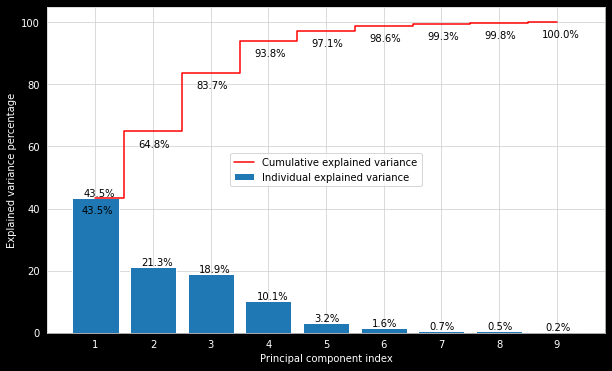

In [439]:
plt.figure(figsize=(10,6))
bars = plt.bar(x_axis, exp_var, align='center', label='Individual explained variance')
steps = plt.step(x_axis, cum_exp_var, where='mid', label='Cumulative explained variance', color='red')

for bar in bars:
  x,width,height = bar.get_x(), bar.get_width(), bar.get_height()
  plt.text(x=x+width/4, y=height+0.50, s="{0}%".format(round(height,1)))

for x,y in steps[0].get_xydata():
  plt.text(x=x-0.25, y=y-5, s="{0}%".format(round(y,1)))

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=x_axis)
plt.legend(loc='center')
plt.show()

In [478]:
VARIANCE_THRESHOLD = 99
n = np.where(cum_exp_var <= VARIANCE_THRESHOLD)[0][-1]
X_pca = PCA(n_components=n+1).fit_transform(X)
print("{0} principal components with a cumulative variance of {1}%".format(n+1, cum_exp_var[n]))
X_pca

6 principal components with a cumulative variance of 98.64846264192748%


array([[ 1.93320336, -2.42809438,  0.03282558,  0.25009134,  1.43653025,
        -0.38202493],
       [ 3.24470138, -2.32789944, -0.10336276,  0.31050467,  0.53067041,
        -0.18487092],
       [-1.08445532, -3.20327495,  0.39317528, -0.39620352,  1.11782587,
        -0.38220502],
       ...,
       [-0.990877  , -1.29265166, -1.32690621, -1.34067143,  0.79694233,
        -0.24629742],
       [-2.20158409, -1.8703098 ,  0.67196103,  0.30579614, -0.3629417 ,
         0.27884869],
       [-1.57436677,  2.17525747,  3.22140717,  0.06888054, -0.38959571,
         0.18354539]])

# sklearn.cluster.KMeans
#### Params
- init: {'k-means++', 'random'} - Selects initial clusters the smart way or by random
- n-init: int, default=10 - Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
- max_iter: int, default=300 - Maximum number of iterations of the k-means algorithm for a single run.
- tol: float, default=1e-4 - Relative tolerance with regards to Frobenius norm of the difference in the cluster centers of two consecutive iterations to declare convergence.
  -  The Frobenius norm is matrix norm of an m×n matrix A defined as the square root of the sum of the absolute squares of its elements.
- random_state: int, RandomState instance or None, default=None - Add a random seed

In [479]:
# Compute k-means
kmeans = [[i, KMeans(n_clusters=i, random_state=0).fit(X_pca)] for i in range(2,10)]
# Retrieve k-means inertia
inertias = list(map(lambda kmean: [kmean[0], kmean[1].inertia_], kmeans))
inertias = pd.DataFrame(inertias)
inertias.columns = ('n_clusters', 'inertia')

# Elbow Method

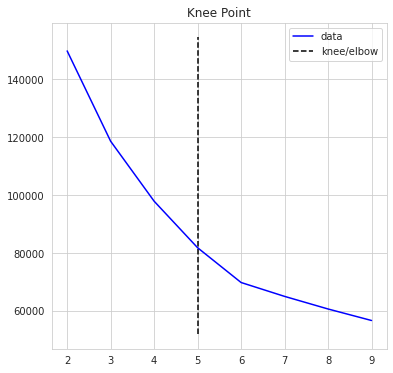

In [489]:
kn = KneeLocator(inertias["n_clusters"], inertias["inertia"], curve='convex', direction='decreasing')
kn.plot_knee()
n = kn.elbow+1

# Silhouette Analysis
Finding k the optimal number of clusters in k-means clustering. Easier to automate than the Elbow Method.

In [490]:
# # Implement silhouette score to determine k for k-means
# highest_score = (None, -np.inf)
# for n_clusters, kmean in kmeans:
#   cluster_labels = kmean.predict(X_pca)
#   silhouette_avg = silhouette_score(X, cluster_labels)
#   highest_score = (n_clusters, silhouette_avg) if (silhouette_avg > highest_score[1]) else highest_score
#   print("For n_clusters = {0}. The average silhouette_score: {1}".format(n_clusters, silhouette_avg))

# n, _ = highest_score

In [491]:
cluster_labels = list(filter(lambda x: x[0]==n, kmeans))[0][1].predict(X_pca)
data['econ_region'] = cluster_labels
data['econ_region'] = data['econ_region'].astype("category")

print("K-means will use {0} clusters.".format(n))
data.head(5)

K-means will use 6 clusters.


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,econ_region
0,2.623418,-0.672608,-1.083122,1.367000,1.771212,-0.362998,-0.072109,-1.251656,-1.213134,4
1,2.543560,-0.574297,-0.765205,2.303469,3.240469,-0.262204,-0.095687,-1.079894,-1.098902,0
2,2.498640,-0.906681,-0.924164,-0.880893,-0.865368,-0.965993,-1.002110,-1.168880,-1.050440,4
3,2.493649,-0.930088,-1.162601,-0.522020,-0.477846,-0.805076,-0.716560,-0.358064,-1.156884,4
4,2.493649,-0.962858,-0.685726,-0.543617,-0.503998,-0.708703,-0.622251,-1.024640,-1.225250,4


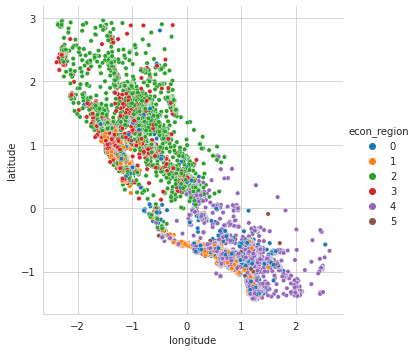

In [496]:
sns.set_style('whitegrid')
sns.relplot(x='longitude', y='latitude', hue='econ_region', data=data, kind='scatter', s=20)
plt.show()

In [493]:
median_attributes = ['median_house_value', 'median_income', 'housing_median_age']
income_house = df[median_attributes]
income_house.groupby(cluster_labels).describe()

median_house_value                                                    \
               count           mean            std       min       25%   
0             2595.0  226778.265125  106177.389850   37500.0  146300.0   
1             2417.0  410650.381465   81946.442187  112500.0  344000.0   
2             3801.0  143008.629045   69023.852576   14999.0   88800.0   
3             3114.0  194160.773282  107430.865173   14999.0  101400.0   
4             7706.0  172830.976252   69589.386866   14999.0  122800.0   
5              367.0  219604.400545  102594.243292   22500.0  142750.0   

                                median_income            ...           \
        50%       75%       max         count      mean  ...      75%   
0  208000.0  284850.0  500001.0        2595.0  4.111070  ...  5.04330   
1  414700.0  500001.0  500001.0        2417.0  7.012126  ...  7.95560   
2  127600.0  185600.0  450000.0        3801.0  3.353093  ...  4.22270   
3  177550.0  263875.0  500001.0        3114.0  3.244285  ...  4.06045   
4  166400.0  216800.0  500001.0        7706.0  3.286113  ...  4.11900   
5  197700.0  273350.0  500001.0         367.0  4.510928  ...  5.51500   

           housing_median_age                                                \
       max              count       mean        std   min   25%   50%   75%   
0  13.9470             2595.0  19.153757   9.245884   2.0  13.0  18.0  25.0   
1  15.0001             2417.0  30.281754  12.383115   2.0  21.0  31.0  38.0   
2   7.7852             3801.0  19.599316   7.072570   1.0  15.0  19.0  25.0   
3   7.7006             3114.0  42.141297   7.444577  19.0  36.0  42.0  50.0   
4   7.7320             7706.0  31.062549  10.977955   1.0  24.0  33.0  38.0   
5   9.8413              367.0  12.444142   7.902515   2.0   5.5  11.0  17.0   

         
    max  
0  52.0  
1  52.0  
2  39.0  
3  52.0  
4  52.0  
5  52.0  

[6 rows x 24 columns]

# Feature selection w/ Random Forest


---
## [Irrelavant for current project] Notes to implement a decision tree
### Measure Entropy
Entropy = $\sum(-p \cdot \log_2{(p_i)})$ \\
$p_i$ = probability of class $i$ \\
### Determine Information Gained (IG)
$IG_i = E(\text{parent}) - \sum(w_i \cdot E(\text{child}_i))$

Compare Information Gained of all class $i$ to determine which value has more IG.

*** $log_2$ for binary tree, or $log_n$ for n-tree

# References
https://www.kaggle.com/code/benherbertson/california-housing-k-means-clustering/notebook

https://towardsdatascience.com/how-to-select-the-best-number-of-principal-components-for-the-dataset-287e64b14c6d

